Loaded 7839 games.
Unique players: 63001


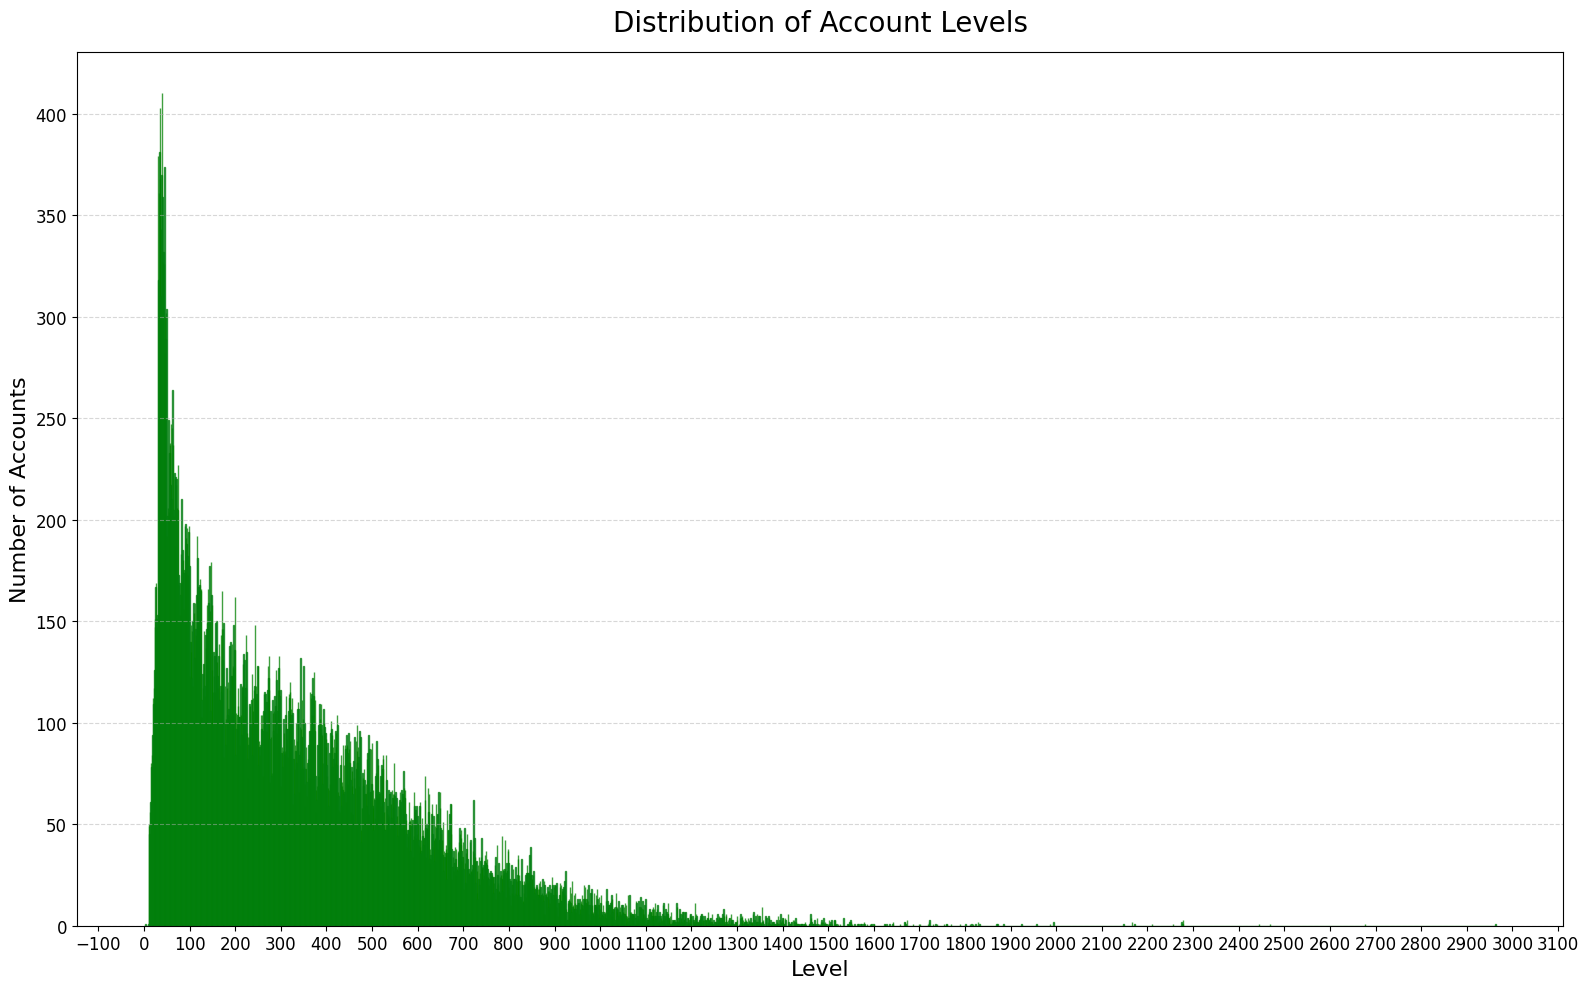

"Qnoxs #17165" Level: 2963
0.5225496091401083


In [7]:
import json
import os
import math

def load_game(filename: str) -> dict:
    """Load game data from a JSON file."""
    with open(filename, 'r') as file:
        data = json.load(file)
    return data


games = []
game_path = os.path.join(".", "games", "classic")

for file in os.listdir(game_path):
    if file.endswith(".json"):
        game_data = load_game(os.path.join(game_path, file))
        games.append(game_data)

print(f"Loaded {len(games)} games.")

players = []
players_name_lvl = {}
for game in games:
    for participant in game.get("info").get("participants", []):
        players_name_lvl[participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")] = participant.get("summonerLevel", 0)

for name, level in players_name_lvl.items():
    players.append((name, level))

print(f"Unique players: {len(players)}")

def plot_level_distribution(games: list):
    import matplotlib.pyplot as plt

    # Levels einsammeln
    levels = []
    for game in games:
        for participant in game.get("info", {}).get("participants", []):
            levels.append(participant.get("summonerLevel", 0))

    # Figur
    plt.figure(figsize=(16, 10))

    # Histogramm mit schöneren Styles
    plt.hist(
        levels,
        bins=range(1, max(levels) + 2),
        edgecolor="green",        # dünne Linien für klarere Balken
        alpha=0.75,               # etwas Transparenz
        linewidth=1.0
    )
    plt.locator_params(axis="x", nbins=40)
    # Titel und Achsen
    plt.title("Distribution of Account Levels", fontsize=20, pad=15)
    plt.xlabel("Level", fontsize=16)
    plt.ylabel("Number of Accounts", fontsize=16)

    # Schönes Grid
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Ticks lesbarer machen
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Layout optimieren
    plt.tight_layout()

    plt.show()

        

def get_team_levels(game: dict) -> tuple:
    team1_levels = []
    team2_levels = []
    for participant in game.get("info").get("participants", []):
        if participant.get("teamId") == 100:
            team1_levels.append(participant.get("summonerLevel", 0))
        else:
            team2_levels.append(participant.get("summonerLevel", 0))
    return sum(team1_levels) / len(team1_levels), sum(team2_levels) / len(team2_levels)

def get_team_min_max_level(game: dict) -> tuple:
    team1_max_level = 0
    team1_min_level = math.inf
    team2_max_level = 0
    team2_min_level = math.inf

    for p in game.get("info").get("participants", []):
        if p.get("teamId") == 100:
            if p.get("summonerLevel", 0) > team1_max_level:
                team1_max_level = p.get("summonerLevel", 0)
            if p.get("summonerLevel", 0) < team1_min_level:
                team1_min_level = p.get("summonerLevel", 0)
        if p.get("teamId") == 200:
            if p.get("summonerLevel", 0) > team2_max_level:
                team2_max_level = p.get("summonerLevel", 0)
            if p.get("summonerLevel", 0) < team2_min_level:
                team2_min_level = p.get("summonerLevel", 0)
    return ((team1_min_level, team1_max_level), (team2_min_level, team2_max_level))

def higher_absolute_level_winrate(games:list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_max_level = 0
    won_with_lower_max_level = 0

    for game in games:
        l = get_team_min_max_level(game)
        team1_min_level, team1_max_level = l[0]
        team2_min_level, team2_max_level = l[1]
        team1_win = False
        team2_win = False

        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True

        if team1_max_level > team2_max_level and abs(team1_max_level - team2_max_level) > difference:
            all_games += 1
            if team1_win:
                won_with_higher_max_level += 1
            if team2_win:
                won_with_lower_max_level += 1

        if team2_max_level > team1_max_level and abs(team1_max_level - team2_max_level) > difference:
            all_games += 1
            if team1_win:
                won_with_lower_max_level += 1
            if team2_win:
                won_with_higher_max_level += 1
    return won_with_higher_max_level/all_games

def higher_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    #print(f"{won_with_higher_level} Wins with higher level and {won_with_lower_level} Wins with lower level of {all_games} games")
    if all_games > 0:
        return won_with_higher_level/all_games
    else:
        return 0
    
def lower_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    #print(f"{won_with_higher_level} Wins with higher level and {won_with_lower_level} Wins with lower level of {all_games} games")
    if all_games > 0:
        return won_with_lower_level/all_games
    else:
        return 0

def get_highest_level_player(games: list) -> tuple:
    highest_level = -1
    player_name = ""
    for game in games:
        for participant in game.get("info").get("participants", []):
            level = participant.get("summonerLevel", 0)
            if level > highest_level:
                highest_level = level
                player_name = participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")
    return player_name, highest_level

plot_level_distribution(games)
hname, hlevel = get_highest_level_player(games)
print(f"\"{hname}\" Level: {hlevel}")

print(higher_level_winrate(games, 200))


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600]


[0.5105269873676151, 0.5112883601460051, 0.5105195362816659, 0.5101041028781383, 0.5080117724002616, 0.5090434782608696, 0.512341062079282, 0.5129492069865489, 0.516504854368932, 0.5151022304832714, 0.5174316528718335, 0.5153909016616726, 0.5133136094674556, 0.5101123595505618, 0.5082369435681738, 0.5101260985861674, 0.5093322272915802, 0.5063578564940963, 0.5099601593625498, 0.513129102844639, 0.5225496091401083, 0.5210803689064558, 0.5206258890469416, 0.5094488188976378, 0.5146299483648882, 0.51252408477842, 0.5144694533762058, 0.5186480186480187, 0.5287958115183246, 0.5381294964028777, 0.5473515248796148, 0.5518453427065027, 0.547244094488189, 0.5592105263157895, 0.5662650602409639, 0.5611702127659575, 0.551622418879056, 0.5504885993485342, 0.553030303030303, 0.5427350427350427, 0.5263157894736842, 0.5454545454545454, 0.5470588235294118, 0.5657894736842105, 0.5777777777777777, 0.5630252100840336, 0.5636363636363636, 0.5463917525773195, 0.5411764705882353, 0.5675675675675675, 0.56451

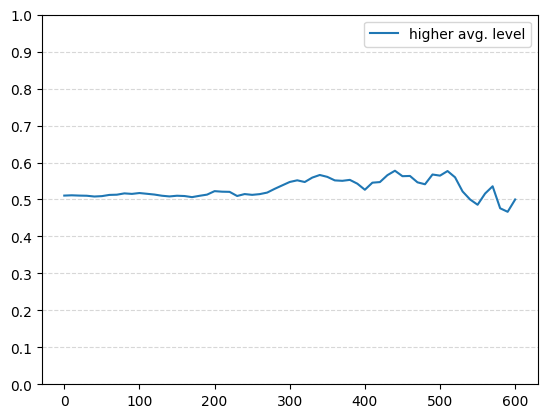

In [8]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 61)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_level_winrate(games, d)
    winrates_higher.append(wr)
    winrates_lower.append(lower_level_winrate(games, d))
print(winrates_higher)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 11)])
plt.plot(diffs, winrates_higher, label="higher avg. level")
#plt.plot(diffs, winrates_lower, label="lower avg. level")
plt.legend()
plt.show()

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000]
[0.5123228195632742, 0.5127969549809687, 0.5139544290144263, 0.5138773244518456, 0.5149392423159399, 0.5153970826580226, 0.51616330247382, 0.5164011246485474, 0.5163008392511298, 0.515929941618015, 0.5154336954647353, 0.5171799893181414, 0.5152073732718894, 0.5154521175123998, 0.5156003159557662, 0.5164588018810059, 0.5151386830404404, 0.5161290322580645, 0.5186533212010919, 0.5191900164822227, 0.5192354814996324, 0.5201827875095202, 0.5198833510074231, 0.5208967616938832, 0.5181792155740051, 0.5164

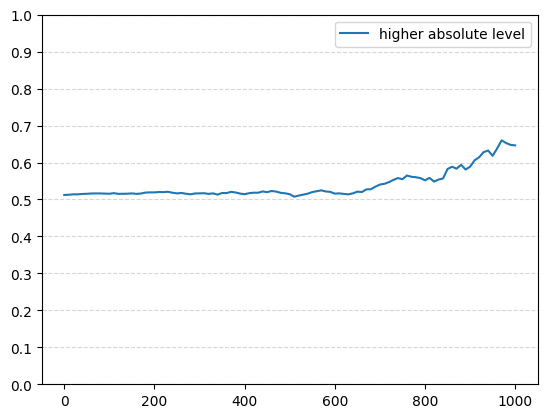

In [9]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 101)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_absolute_level_winrate(games, d)
    winrates_higher.append(wr)
print(winrates_higher)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 11)])
plt.plot(diffs, winrates_higher, label="higher absolute level")
plt.legend()
plt.show()